In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import os

In [12]:
data_root = '/home/vpadole/celeba_data'  # Path to CelebA images
output_dir = './dcgan_output-3'
os.makedirs(output_dir, exist_ok=True)

batch_size = 128
image_size = 64
z_dim = 100
num_epochs = 50
lr = 0.0002
beta1 = 0.5

In [13]:
import zipfile

# Unzip CelebA if not already unzipped
zip_path = '/home/vpadole/archive (5).zip'
unzip_path = '/home/vpadole/celeba_data'

if not os.path.exists(unzip_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)
    print("Unzipping Complete!")


In [14]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataset = dset.ImageFolder(root=data_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/home/vpadole/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [33]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
netG = Generator(z_dim).to(device)
netD = Discriminator().to(device)

netG.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.BatchNorm2d)) else None)
netD.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.BatchNorm2d)) else None)


TypeError: Generator.__init__() missing 1 required positional argument: 'embedding_dim'

In [38]:
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)


In [39]:
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)

        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print statistics
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \tLoss_D: {errD.item():.4f} \tLoss_G: {errG.item():.4f} \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Save fake images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    vutils.save_image((fake + 1) / 2, f"{output_dir}/fake_samples_epoch_{epoch+1}.png", normalize=True)

# Save the final models
torch.save(netG.state_dict(), os.path.join(output_dir, 'generator.pth'))
torch.save(netD.state_dict(), os.path.join(output_dir, 'discriminator.pth'))
print("Training Complete and Models Saved!")


Starting Training Loop...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0/50][0/235] 	Loss_D: 0.3977 	Loss_G: 0.1512 	D(x): 0.7489 	D(G(z)): 0.0746 / 0.8702
[0/50][100/235] 	Loss_D: 0.2236 	Loss_G: 3.3406 	D(x): 0.9326 	D(G(z)): 0.1328 / 0.0526
[0/50][200/235] 	Loss_D: 1.0424 	Loss_G: 0.6823 	D(x): 0.4269 	D(G(z)): 0.0345 / 0.5800


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[1/50][0/235] 	Loss_D: 0.7902 	Loss_G: 1.4684 	D(x): 0.5196 	D(G(z)): 0.0308 / 0.2953
[1/50][100/235] 	Loss_D: 0.8583 	Loss_G: 4.2723 	D(x): 0.8817 	D(G(z)): 0.4592 / 0.0211
[1/50][200/235] 	Loss_D: 0.3260 	Loss_G: 2.9839 	D(x): 0.7663 	D(G(z)): 0.0365 / 0.0719


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[2/50][0/235] 	Loss_D: 0.4216 	Loss_G: 2.2161 	D(x): 0.7365 	D(G(z)): 0.0807 / 0.1640
[2/50][100/235] 	Loss_D: 0.4877 	Loss_G: 1.5443 	D(x): 0.6811 	D(G(z)): 0.0503 / 0.2691
[2/50][200/235] 	Loss_D: 0.3049 	Loss_G: 2.5278 	D(x): 0.8326 	D(G(z)): 0.0989 / 0.1111


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[3/50][0/235] 	Loss_D: 0.3465 	Loss_G: 3.9620 	D(x): 0.9235 	D(G(z)): 0.2070 / 0.0275
[3/50][100/235] 	Loss_D: 1.0982 	Loss_G: 1.2050 	D(x): 0.4350 	D(G(z)): 0.0860 / 0.3550
[3/50][200/235] 	Loss_D: 0.3333 	Loss_G: 3.1146 	D(x): 0.8934 	D(G(z)): 0.1791 / 0.0639


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[4/50][0/235] 	Loss_D: 0.4774 	Loss_G: 5.3256 	D(x): 0.9642 	D(G(z)): 0.3256 / 0.0075
[4/50][100/235] 	Loss_D: 0.4113 	Loss_G: 3.6660 	D(x): 0.9028 	D(G(z)): 0.2414 / 0.0371
[4/50][200/235] 	Loss_D: 0.2841 	Loss_G: 3.2174 	D(x): 0.9102 	D(G(z)): 0.1588 / 0.0577


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[5/50][0/235] 	Loss_D: 0.4026 	Loss_G: 1.2949 	D(x): 0.7356 	D(G(z)): 0.0611 / 0.3535
[5/50][100/235] 	Loss_D: 0.2686 	Loss_G: 3.3307 	D(x): 0.8730 	D(G(z)): 0.1095 / 0.0566
[5/50][200/235] 	Loss_D: 0.2936 	Loss_G: 2.6779 	D(x): 0.8612 	D(G(z)): 0.1167 / 0.1017


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[6/50][0/235] 	Loss_D: 0.6511 	Loss_G: 3.6989 	D(x): 0.8956 	D(G(z)): 0.3622 / 0.0421
[6/50][100/235] 	Loss_D: 0.4035 	Loss_G: 2.8602 	D(x): 0.9039 	D(G(z)): 0.2343 / 0.0784
[6/50][200/235] 	Loss_D: 0.3961 	Loss_G: 2.3589 	D(x): 0.7401 	D(G(z)): 0.0654 / 0.1386


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[7/50][0/235] 	Loss_D: 2.7040 	Loss_G: 5.8453 	D(x): 0.9905 	D(G(z)): 0.8835 / 0.0050
[7/50][100/235] 	Loss_D: 0.2817 	Loss_G: 3.2095 	D(x): 0.8460 	D(G(z)): 0.0886 / 0.0617
[7/50][200/235] 	Loss_D: 0.3416 	Loss_G: 2.5919 	D(x): 0.8107 	D(G(z)): 0.0966 / 0.1078


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[8/50][0/235] 	Loss_D: 0.2085 	Loss_G: 3.5187 	D(x): 0.9453 	D(G(z)): 0.1301 / 0.0489
[8/50][100/235] 	Loss_D: 0.2904 	Loss_G: 2.3087 	D(x): 0.8102 	D(G(z)): 0.0563 / 0.1543
[8/50][200/235] 	Loss_D: 0.4953 	Loss_G: 4.7109 	D(x): 0.9380 	D(G(z)): 0.3050 / 0.0149


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[9/50][0/235] 	Loss_D: 0.3994 	Loss_G: 2.5401 	D(x): 0.7771 	D(G(z)): 0.1006 / 0.1149
[9/50][100/235] 	Loss_D: 0.3134 	Loss_G: 3.0254 	D(x): 0.8904 	D(G(z)): 0.1660 / 0.0729
[9/50][200/235] 	Loss_D: 0.3787 	Loss_G: 3.5811 	D(x): 0.8927 	D(G(z)): 0.2089 / 0.0424


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[10/50][0/235] 	Loss_D: 0.3484 	Loss_G: 5.5064 	D(x): 0.9737 	D(G(z)): 0.2449 / 0.0065
[10/50][100/235] 	Loss_D: 0.5395 	Loss_G: 1.3118 	D(x): 0.6393 	D(G(z)): 0.0378 / 0.3626
[10/50][200/235] 	Loss_D: 1.2266 	Loss_G: 3.5144 	D(x): 0.9607 	D(G(z)): 0.5920 / 0.0511


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[11/50][0/235] 	Loss_D: 0.6792 	Loss_G: 5.5354 	D(x): 0.9691 	D(G(z)): 0.4152 / 0.0066
[11/50][100/235] 	Loss_D: 0.2322 	Loss_G: 2.8018 	D(x): 0.8700 	D(G(z)): 0.0791 / 0.0947
[11/50][200/235] 	Loss_D: 2.2747 	Loss_G: 5.5540 	D(x): 0.9858 	D(G(z)): 0.8363 / 0.0076


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[12/50][0/235] 	Loss_D: 0.4907 	Loss_G: 4.4400 	D(x): 0.9831 	D(G(z)): 0.3274 / 0.0204
[12/50][100/235] 	Loss_D: 0.3093 	Loss_G: 4.5313 	D(x): 0.9424 	D(G(z)): 0.2019 / 0.0174
[12/50][200/235] 	Loss_D: 0.6731 	Loss_G: 3.3267 	D(x): 0.8239 	D(G(z)): 0.3362 / 0.0563


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[13/50][0/235] 	Loss_D: 0.3554 	Loss_G: 3.9514 	D(x): 0.8603 	D(G(z)): 0.1538 / 0.0341
[13/50][100/235] 	Loss_D: 0.4862 	Loss_G: 5.4170 	D(x): 0.9582 	D(G(z)): 0.3186 / 0.0071
[13/50][200/235] 	Loss_D: 0.4514 	Loss_G: 2.0892 	D(x): 0.6915 	D(G(z)): 0.0310 / 0.1968


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[14/50][0/235] 	Loss_D: 0.2174 	Loss_G: 4.1449 	D(x): 0.9370 	D(G(z)): 0.1310 / 0.0237
[14/50][100/235] 	Loss_D: 0.3038 	Loss_G: 3.1614 	D(x): 0.8215 	D(G(z)): 0.0804 / 0.0701
[14/50][200/235] 	Loss_D: 1.2614 	Loss_G: 6.0344 	D(x): 0.9879 	D(G(z)): 0.6435 / 0.0040


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[15/50][0/235] 	Loss_D: 0.2605 	Loss_G: 3.1735 	D(x): 0.8504 	D(G(z)): 0.0779 / 0.0704
[15/50][100/235] 	Loss_D: 0.6860 	Loss_G: 5.0543 	D(x): 0.9179 	D(G(z)): 0.3920 / 0.0123
[15/50][200/235] 	Loss_D: 0.3431 	Loss_G: 2.4124 	D(x): 0.8231 	D(G(z)): 0.1159 / 0.1292


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[16/50][0/235] 	Loss_D: 0.3507 	Loss_G: 2.8909 	D(x): 0.8480 	D(G(z)): 0.1444 / 0.0809
[16/50][100/235] 	Loss_D: 0.2537 	Loss_G: 3.3878 	D(x): 0.9254 	D(G(z)): 0.1429 / 0.0518
[16/50][200/235] 	Loss_D: 0.9759 	Loss_G: 5.3739 	D(x): 0.9218 	D(G(z)): 0.5096 / 0.0106


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[17/50][0/235] 	Loss_D: 0.3165 	Loss_G: 3.6770 	D(x): 0.9229 	D(G(z)): 0.1891 / 0.0396
[17/50][100/235] 	Loss_D: 0.2705 	Loss_G: 2.3137 	D(x): 0.8813 	D(G(z)): 0.1213 / 0.1486
[17/50][200/235] 	Loss_D: 0.7442 	Loss_G: 4.9407 	D(x): 0.9527 	D(G(z)): 0.4309 / 0.0122


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[18/50][0/235] 	Loss_D: 0.2637 	Loss_G: 2.9613 	D(x): 0.9007 	D(G(z)): 0.1325 / 0.0849
[18/50][100/235] 	Loss_D: 0.2257 	Loss_G: 3.8804 	D(x): 0.8583 	D(G(z)): 0.0586 / 0.0343
[18/50][200/235] 	Loss_D: 0.6271 	Loss_G: 1.8546 	D(x): 0.5913 	D(G(z)): 0.0200 / 0.2396


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[19/50][0/235] 	Loss_D: 0.5198 	Loss_G: 5.2376 	D(x): 0.9792 	D(G(z)): 0.3441 / 0.0096
[19/50][100/235] 	Loss_D: 0.1973 	Loss_G: 3.4863 	D(x): 0.9179 	D(G(z)): 0.0965 / 0.0479
[19/50][200/235] 	Loss_D: 0.1846 	Loss_G: 3.2566 	D(x): 0.8895 	D(G(z)): 0.0581 / 0.0650


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[20/50][0/235] 	Loss_D: 0.4258 	Loss_G: 2.1685 	D(x): 0.8144 	D(G(z)): 0.1648 / 0.1762
[20/50][100/235] 	Loss_D: 0.2550 	Loss_G: 2.7182 	D(x): 0.8333 	D(G(z)): 0.0529 / 0.1016
[20/50][200/235] 	Loss_D: 0.2334 	Loss_G: 3.9294 	D(x): 0.9538 	D(G(z)): 0.1550 / 0.0318


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[21/50][0/235] 	Loss_D: 2.7070 	Loss_G: 0.5368 	D(x): 0.1255 	D(G(z)): 0.0386 / 0.6305
[21/50][100/235] 	Loss_D: 0.1609 	Loss_G: 3.6825 	D(x): 0.9155 	D(G(z)): 0.0647 / 0.0419
[21/50][200/235] 	Loss_D: 0.2791 	Loss_G: 3.7205 	D(x): 0.8819 	D(G(z)): 0.1200 / 0.0436


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[22/50][0/235] 	Loss_D: 0.7081 	Loss_G: 5.1899 	D(x): 0.9906 	D(G(z)): 0.4237 / 0.0113
[22/50][100/235] 	Loss_D: 0.2752 	Loss_G: 2.6204 	D(x): 0.8693 	D(G(z)): 0.1107 / 0.1145
[22/50][200/235] 	Loss_D: 0.4732 	Loss_G: 4.2162 	D(x): 0.9394 	D(G(z)): 0.2843 / 0.0267


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[23/50][0/235] 	Loss_D: 0.2470 	Loss_G: 2.8280 	D(x): 0.8686 	D(G(z)): 0.0870 / 0.0886
[23/50][100/235] 	Loss_D: 0.8685 	Loss_G: 0.7127 	D(x): 0.4909 	D(G(z)): 0.0256 / 0.5695
[23/50][200/235] 	Loss_D: 0.9040 	Loss_G: 5.7334 	D(x): 0.9498 	D(G(z)): 0.4941 / 0.0067


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[24/50][0/235] 	Loss_D: 0.2190 	Loss_G: 3.5585 	D(x): 0.9390 	D(G(z)): 0.1316 / 0.0449
[24/50][100/235] 	Loss_D: 0.1586 	Loss_G: 3.6116 	D(x): 0.9459 	D(G(z)): 0.0918 / 0.0395
[24/50][200/235] 	Loss_D: 0.3644 	Loss_G: 4.4173 	D(x): 0.9560 	D(G(z)): 0.2370 / 0.0196


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[25/50][0/235] 	Loss_D: 0.2810 	Loss_G: 3.5065 	D(x): 0.8888 	D(G(z)): 0.1309 / 0.0497
[25/50][100/235] 	Loss_D: 0.3880 	Loss_G: 1.9918 	D(x): 0.7301 	D(G(z)): 0.0341 / 0.2162
[25/50][200/235] 	Loss_D: 0.3045 	Loss_G: 2.9176 	D(x): 0.8254 	D(G(z)): 0.0811 / 0.0875


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[26/50][0/235] 	Loss_D: 0.2811 	Loss_G: 3.5769 	D(x): 0.7941 	D(G(z)): 0.0212 / 0.0501
[26/50][100/235] 	Loss_D: 0.4173 	Loss_G: 3.2581 	D(x): 0.7514 	D(G(z)): 0.0856 / 0.0725
[26/50][200/235] 	Loss_D: 0.1669 	Loss_G: 4.0143 	D(x): 0.9147 	D(G(z)): 0.0639 / 0.0333


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[27/50][0/235] 	Loss_D: 0.1565 	Loss_G: 3.6488 	D(x): 0.9157 	D(G(z)): 0.0595 / 0.0452
[27/50][100/235] 	Loss_D: 0.1695 	Loss_G: 3.2896 	D(x): 0.8973 	D(G(z)): 0.0508 / 0.0611
[27/50][200/235] 	Loss_D: 0.3651 	Loss_G: 3.7323 	D(x): 0.7356 	D(G(z)): 0.0150 / 0.0443


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[28/50][0/235] 	Loss_D: 0.1881 	Loss_G: 4.1088 	D(x): 0.9636 	D(G(z)): 0.1271 / 0.0253
[28/50][100/235] 	Loss_D: 0.3112 	Loss_G: 4.1615 	D(x): 0.9521 	D(G(z)): 0.2066 / 0.0243
[28/50][200/235] 	Loss_D: 1.5571 	Loss_G: 0.9319 	D(x): 0.3050 	D(G(z)): 0.0492 / 0.4766


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[29/50][0/235] 	Loss_D: 0.3616 	Loss_G: 5.4521 	D(x): 0.9680 	D(G(z)): 0.2490 / 0.0065
[29/50][100/235] 	Loss_D: 0.3866 	Loss_G: 4.8482 	D(x): 0.9753 	D(G(z)): 0.2638 / 0.0134
[29/50][200/235] 	Loss_D: 0.2416 	Loss_G: 3.5175 	D(x): 0.8105 	D(G(z)): 0.0162 / 0.0513


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[30/50][0/235] 	Loss_D: 0.2632 	Loss_G: 4.1296 	D(x): 0.9584 	D(G(z)): 0.1740 / 0.0268
[30/50][100/235] 	Loss_D: 0.2439 	Loss_G: 2.9042 	D(x): 0.8605 	D(G(z)): 0.0731 / 0.0922
[30/50][200/235] 	Loss_D: 0.2767 	Loss_G: 3.5769 	D(x): 0.9071 	D(G(z)): 0.1427 / 0.0462


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[31/50][0/235] 	Loss_D: 0.7791 	Loss_G: 6.9561 	D(x): 0.9904 	D(G(z)): 0.4537 / 0.0017
[31/50][100/235] 	Loss_D: 0.1839 	Loss_G: 3.1762 	D(x): 0.8724 	D(G(z)): 0.0369 / 0.0781
[31/50][200/235] 	Loss_D: 0.5485 	Loss_G: 2.4276 	D(x): 0.6642 	D(G(z)): 0.0537 / 0.1501


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[32/50][0/235] 	Loss_D: 0.3085 	Loss_G: 5.4248 	D(x): 0.9745 	D(G(z)): 0.2227 / 0.0076
[32/50][100/235] 	Loss_D: 0.1259 	Loss_G: 3.8190 	D(x): 0.9639 	D(G(z)): 0.0802 / 0.0402
[32/50][200/235] 	Loss_D: 0.1822 	Loss_G: 3.3885 	D(x): 0.8963 	D(G(z)): 0.0622 / 0.0580


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[33/50][0/235] 	Loss_D: 0.2820 	Loss_G: 2.4858 	D(x): 0.8223 	D(G(z)): 0.0600 / 0.1342
[33/50][100/235] 	Loss_D: 0.2031 	Loss_G: 3.7834 	D(x): 0.8951 	D(G(z)): 0.0785 / 0.0421
[33/50][200/235] 	Loss_D: 0.4067 	Loss_G: 5.1983 	D(x): 0.8944 	D(G(z)): 0.2082 / 0.0111


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[34/50][0/235] 	Loss_D: 0.1581 	Loss_G: 3.8426 	D(x): 0.9209 	D(G(z)): 0.0663 / 0.0393
[34/50][100/235] 	Loss_D: 0.1582 	Loss_G: 3.3584 	D(x): 0.9024 	D(G(z)): 0.0475 / 0.0573
[34/50][200/235] 	Loss_D: 0.3689 	Loss_G: 3.6674 	D(x): 0.7470 	D(G(z)): 0.0192 / 0.0591


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[35/50][0/235] 	Loss_D: 1.1990 	Loss_G: 1.0978 	D(x): 0.4896 	D(G(z)): 0.2189 / 0.4307
[35/50][100/235] 	Loss_D: 0.2608 	Loss_G: 2.2964 	D(x): 0.8268 	D(G(z)): 0.0443 / 0.1576
[35/50][200/235] 	Loss_D: 0.2055 	Loss_G: 4.0189 	D(x): 0.9494 	D(G(z)): 0.1310 / 0.0300


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[36/50][0/235] 	Loss_D: 0.5025 	Loss_G: 5.8253 	D(x): 0.9952 	D(G(z)): 0.3420 / 0.0049
[36/50][100/235] 	Loss_D: 0.1634 	Loss_G: 3.4526 	D(x): 0.9138 	D(G(z)): 0.0636 / 0.0559
[36/50][200/235] 	Loss_D: 0.3871 	Loss_G: 4.4615 	D(x): 0.9689 	D(G(z)): 0.2643 / 0.0178


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[37/50][0/235] 	Loss_D: 0.3692 	Loss_G: 3.0023 	D(x): 0.7689 	D(G(z)): 0.0536 / 0.0945
[37/50][100/235] 	Loss_D: 0.1966 	Loss_G: 3.5916 	D(x): 0.9318 	D(G(z)): 0.1066 / 0.0470
[37/50][200/235] 	Loss_D: 0.4793 	Loss_G: 2.5327 	D(x): 0.7047 	D(G(z)): 0.0537 / 0.1526


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[38/50][0/235] 	Loss_D: 0.1956 	Loss_G: 4.0598 	D(x): 0.9654 	D(G(z)): 0.1303 / 0.0312
[38/50][100/235] 	Loss_D: 0.2535 	Loss_G: 2.2352 	D(x): 0.8362 	D(G(z)): 0.0567 / 0.1493
[38/50][200/235] 	Loss_D: 0.3859 	Loss_G: 2.0900 	D(x): 0.8173 	D(G(z)): 0.1126 / 0.2072


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[39/50][0/235] 	Loss_D: 0.6235 	Loss_G: 6.0728 	D(x): 0.9547 	D(G(z)): 0.3666 / 0.0050
[39/50][100/235] 	Loss_D: 0.1073 	Loss_G: 3.6811 	D(x): 0.9642 	D(G(z)): 0.0634 / 0.0449
[39/50][200/235] 	Loss_D: 0.1787 	Loss_G: 3.5591 	D(x): 0.8769 	D(G(z)): 0.0356 / 0.0508


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[40/50][0/235] 	Loss_D: 0.8474 	Loss_G: 7.9221 	D(x): 0.9695 	D(G(z)): 0.4770 / 0.0013
[40/50][100/235] 	Loss_D: 0.1161 	Loss_G: 4.0908 	D(x): 0.9498 	D(G(z)): 0.0571 / 0.0295
[40/50][200/235] 	Loss_D: 0.1617 	Loss_G: 3.5482 	D(x): 0.9241 	D(G(z)): 0.0694 / 0.0529


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[41/50][0/235] 	Loss_D: 0.2771 	Loss_G: 1.9138 	D(x): 0.7919 	D(G(z)): 0.0219 / 0.2353
[41/50][100/235] 	Loss_D: 0.2097 	Loss_G: 4.1337 	D(x): 0.9758 	D(G(z)): 0.1531 / 0.0304
[41/50][200/235] 	Loss_D: 0.3026 	Loss_G: 2.4879 	D(x): 0.7967 	D(G(z)): 0.0521 / 0.1313


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[42/50][0/235] 	Loss_D: 0.4891 	Loss_G: 7.5937 	D(x): 0.9938 	D(G(z)): 0.3359 / 0.0009
[42/50][100/235] 	Loss_D: 0.5446 	Loss_G: 2.9572 	D(x): 0.8067 	D(G(z)): 0.2252 / 0.0922
[42/50][200/235] 	Loss_D: 0.1478 	Loss_G: 4.2864 	D(x): 0.9813 	D(G(z)): 0.1135 / 0.0227


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[43/50][0/235] 	Loss_D: 0.1104 	Loss_G: 4.3250 	D(x): 0.9880 	D(G(z)): 0.0864 / 0.0258
[43/50][100/235] 	Loss_D: 0.1600 	Loss_G: 3.4195 	D(x): 0.9188 	D(G(z)): 0.0661 / 0.0615
[43/50][200/235] 	Loss_D: 0.1103 	Loss_G: 3.7416 	D(x): 0.9509 	D(G(z)): 0.0541 / 0.0464


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[44/50][0/235] 	Loss_D: 0.1127 	Loss_G: 4.0742 	D(x): 0.9825 	D(G(z)): 0.0864 / 0.0272
[44/50][100/235] 	Loss_D: 0.1535 	Loss_G: 3.7646 	D(x): 0.9200 	D(G(z)): 0.0607 / 0.0450
[44/50][200/235] 	Loss_D: 0.1549 	Loss_G: 2.5624 	D(x): 0.9045 	D(G(z)): 0.0472 / 0.1237


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[45/50][0/235] 	Loss_D: 0.1874 	Loss_G: 6.9456 	D(x): 0.9762 	D(G(z)): 0.1373 / 0.0021
[45/50][100/235] 	Loss_D: 1.6737 	Loss_G: 1.5500 	D(x): 0.2911 	D(G(z)): 0.0021 / 0.3235
[45/50][200/235] 	Loss_D: 0.2465 	Loss_G: 4.6973 	D(x): 0.9807 	D(G(z)): 0.1847 / 0.0150


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[46/50][0/235] 	Loss_D: 0.1697 	Loss_G: 5.3397 	D(x): 0.9752 	D(G(z)): 0.1243 / 0.0081
[46/50][100/235] 	Loss_D: 0.1203 	Loss_G: 3.6622 	D(x): 0.9214 	D(G(z)): 0.0336 / 0.0452
[46/50][200/235] 	Loss_D: 0.1856 	Loss_G: 3.2898 	D(x): 0.8715 	D(G(z)): 0.0326 / 0.0679


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[47/50][0/235] 	Loss_D: 0.1842 	Loss_G: 4.2783 	D(x): 0.9769 	D(G(z)): 0.1340 / 0.0259
[47/50][100/235] 	Loss_D: 0.1564 	Loss_G: 4.2727 	D(x): 0.8970 	D(G(z)): 0.0350 / 0.0280
[47/50][200/235] 	Loss_D: 0.9712 	Loss_G: 1.8636 	D(x): 0.4510 	D(G(z)): 0.0018 / 0.2516


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[48/50][0/235] 	Loss_D: 0.3199 	Loss_G: 4.3002 	D(x): 0.9851 	D(G(z)): 0.2279 / 0.0245
[48/50][100/235] 	Loss_D: 0.1208 	Loss_G: 4.7298 	D(x): 0.9530 	D(G(z)): 0.0608 / 0.0190
[48/50][200/235] 	Loss_D: 0.2804 	Loss_G: 4.0108 	D(x): 0.9183 	D(G(z)): 0.1467 / 0.0337


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[49/50][0/235] 	Loss_D: 0.1730 	Loss_G: 4.4427 	D(x): 0.9620 	D(G(z)): 0.1145 / 0.0222
[49/50][100/235] 	Loss_D: 0.1300 	Loss_G: 3.5731 	D(x): 0.9066 	D(G(z)): 0.0267 / 0.0606
[49/50][200/235] 	Loss_D: 0.1472 	Loss_G: 4.4911 	D(x): 0.9695 	D(G(z)): 0.1015 / 0.0222
Training Complete and Models Saved!


In [14]:
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import clip
from PIL import Image

ModuleNotFoundError: No module named 'torchmetrics'

Training it again

In [16]:
!pip install torchmetrics


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.3 MB/s eta 0:00:00


In [2]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
import numpy as np
from PIL import Image
import os

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, embedding_dim):
        super(Generator, self).__init__()
        
        # Assuming text_embedding is a vector of embedding_dim size
        self.embedding_dim = embedding_dim

        self.fc = nn.Linear(embedding_dim, 256)  # Linear layer to process text embedding

        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim + 256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, text_embedding):
        # Process text embedding
        text_embedding = self.fc(text_embedding).view(-1, 256, 1, 1)

        # Concatenate noise with processed text embedding
        z = torch.cat([z, text_embedding], 1)  # Concatenate along the channel dimension

        return self.main(z)


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [7]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
import numpy as np
from PIL import Image
import os

# Pretrained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False).eval()

# Transform to match InceptionV3 input size
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def calculate_fid(real_images, generated_images, batch_size=64):
    real_features = []
    fake_features = []
    
    # Extract features for real images
    with torch.no_grad():
        for i in range(0, len(real_images), batch_size):
            batch_real = real_images[i:i+batch_size]
            batch_real = batch_real.to(device)
            features = inception_model(batch_real)
            real_features.append(features.cpu().numpy())
    
    # Extract features for generated images
    with torch.no_grad():
        for i in range(0, len(generated_images), batch_size):
            batch_fake = generated_images[i:i+batch_size]
            batch_fake = batch_fake.to(device)
            features = inception_model(batch_fake)
            fake_features.append(features.cpu().numpy())
    
    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)
    
    # Compute the mean and covariance for both real and fake features
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    cov_fake = np.cov(fake_features, rowvar=False)
    
    # Compute FID
    diff = mu_real - mu_fake
    cov_sqrt, _ = sqrtm(cov_real.dot(cov_fake), disp=False)
    fid = diff.dot(diff) + np.trace(cov_real + cov_fake - 2 * cov_sqrt)
    return fid



/home/vpadole/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vpadole/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch
from torchvision import models
import numpy as np

# Pretrained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False).eval()

# Transform to match InceptionV3 input size
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def calculate_is(generated_images, batch_size=64):
    inception_model.eval()
    probas = []
    
    with torch.no_grad():
        for i in range(0, len(generated_images), batch_size):
            batch_fake = generated_images[i:i+batch_size]
            batch_fake = batch_fake.to(device)
            outputs = inception_model(batch_fake)
            outputs = F.softmax(outputs, dim=1)
            probas.append(outputs.cpu().numpy())
    
    probas = np.concatenate(probas, axis=0)
    # Compute marginal probability distribution (mean over the batch)
    p_y = np.mean(probas, axis=0)
    
    # Compute the KL divergence
    kl_divergence = []
    for i in range(probas.shape[0]):
        kl_div = probas[i] * (np.log(probas[i]) - np.log(p_y))
        kl_divergence.append(np.sum(kl_div))
    
    kl_divergence = np.mean(kl_divergence)
    
    # Calculate the Inception Score
    is_score = np.exp(kl_divergence)
    return is_score


In [9]:
import clip
import torch
import torch.nn.functional as F

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

def calculate_clip_score(generated_images, text, batch_size=64):
    clip_model.eval()
    text_input = clip.tokenize([text]).to(device)
    text_features = clip_model.encode_text(text_input)
    
    clip_scores = []
    with torch.no_grad():
        for i in range(0, len(generated_images), batch_size):
            batch_fake = generated_images[i:i+batch_size]
            batch_fake = batch_fake.to(device)
            image_features = clip_model.encode_image(batch_fake)
            similarity = F.cosine_similarity(image_features, text_features)
            clip_scores.append(similarity.cpu().numpy())
    
    clip_scores = np.concatenate(clip_scores, axis=0)
    return np.mean(clip_scores)


In [10]:
import clip
import torch

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

# Example function to get text embeddings
def get_text_embedding(text):
    text_input = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_input)
    return text_features


In [19]:
from torch.cuda.amp import autocast, GradScaler

# Create a scaler for mixed-precision training
scaler = GradScaler()

# Training loop with AMP enabled
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = data[0].to(device)
        real_images = real_images.float()  # Convert to float32 if it's not already
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)

        with autocast():  # Enable mixed-precision context
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, z_dim, 1, 1, device=device)
            fake = netG(noise, text_embedding)  # Pass noise and text embedding to the Generator
            label.fill_(0.)

            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(1.)
        
        with autocast():  # Enable mixed-precision context
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
        
        # Scaler updates the gradients based on AMP
        scaler.step(optimizerG)
        scaler.update()

        # Print statistics
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \tLoss_D: {errD.item():.4f} \tLoss_G: {errG.item():.4f} \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Save fake images
    with torch.no_grad():
        fake = netG(fixed_noise, text_embedding).detach().cpu()
    vutils.save_image((fake + 1) / 2, f"{output_dir}/fake_samples_epoch_{epoch+1}.png", normalize=True)

# Save the final models
torch.save(netG.state_dict(), os.path.join(output_dir, 'generator.pth'))
torch.save(netD.state_dict(), os.path.join(output_dir, 'discriminator.pth'))
print("Training Complete and Models Saved!")


/tmp/ipykernel_1730745/710969116.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1730745/710969116.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed-precision context


RuntimeError: torch.nn.functional.binary_cross_entropy and torch.nn.BCELoss are unsafe to autocast.
Many models use a sigmoid layer right before the binary cross entropy layer.
In this case, combine the two layers using torch.nn.functional.binary_cross_entropy_with_logits
or torch.nn.BCEWithLogitsLoss.  binary_cross_entropy_with_logits and BCEWithLogits are
safe to autocast.

In [20]:
!pip install torch torchvision torchaudio pytorch-fid git+https://github.com/openai/CLIP.git
!pip install Pillow numpy tqdm

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yl8hwuzx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yl8hwuzx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CelebA-HQ (replace path)
dataset = datasets.ImageFolder(root="/home/vpadole/celeba_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
# Generator and Discriminator (simplified)
class Generator(torch.nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(True),
            # Add more layers...
            torch.nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

# Initialize
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # ... your existing layers ...
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0),  # Output: [batch, 1, 1, 1]
            nn.Flatten()  # Reshapes to [batch, 1]
        )

    def forward(self, x):
        return self.main(x)  # Now outputs [batch_size, 1]

In [23]:
import clip
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()  # Freeze CLIP

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Training:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0/100] D loss: 0.0002, G loss: 10.0514, CLIP loss: -0.1990


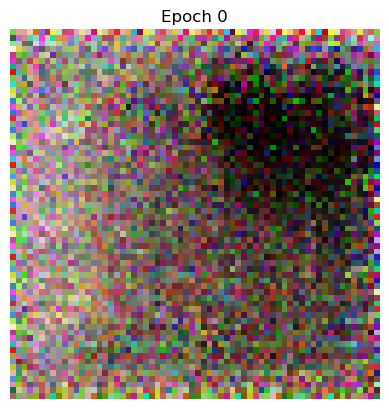

[Epoch 10/100] D loss: 0.0000, G loss: 17.6320, CLIP loss: -0.1881


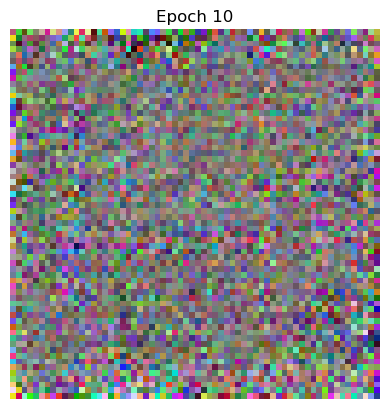

[Epoch 20/100] D loss: 0.0000, G loss: 22.0697, CLIP loss: -0.1786


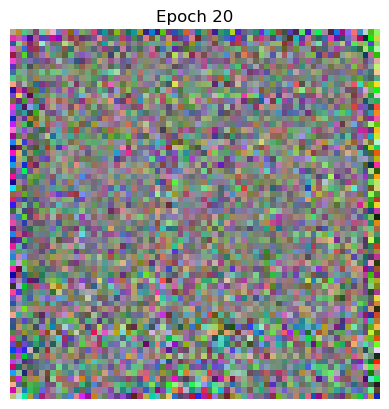

[Epoch 30/100] D loss: 0.0000, G loss: 25.6878, CLIP loss: -0.1890


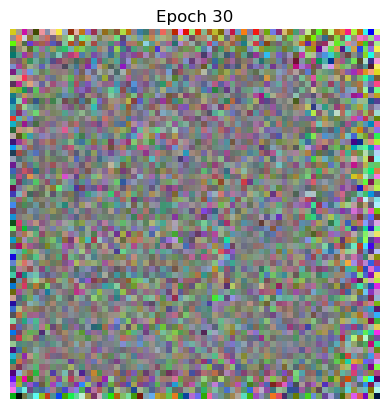

[Epoch 40/100] D loss: 0.0000, G loss: 26.4848, CLIP loss: -0.1904


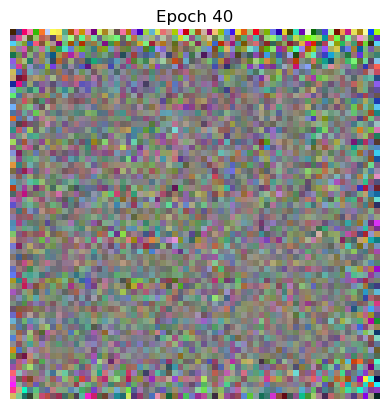

[Epoch 50/100] D loss: 0.0000, G loss: 27.1439, CLIP loss: -0.1937


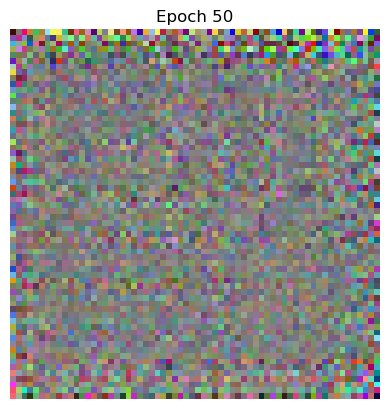

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ====================
# 1. Configuration
# ====================
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 100
img_size = 256
batch_size = 32
epochs = 100
lambda_clip = 0.1  # CLIP loss weight

# ====================
# 2. Define DCGAN Models
# ====================
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output: 3 x 256 x 256
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 3x256x256
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # Final layer produces 1x13x13 output (PatchGAN)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)  # Output: [batch, 1, 13, 13]
        )

    def forward(self, x):
        return self.main(x)

# ====================
# 3. Load CLIP
# ====================
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# ====================
# 4. Data Preparation
# ====================
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root="/home/vpadole/celeba_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ====================
# 5. Training Setup
# ====================
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Custom PatchGAN loss
def patchgan_loss(disc_output, target_is_real):
    target = torch.full_like(disc_output, 1.0 if target_is_real else 0.0)
    return F.binary_cross_entropy_with_logits(disc_output, target)

# ====================
# 6. Training Loop
# ====================
for epoch in tqdm(range(epochs), desc="Training"):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        current_batch_size = real_imgs.size(0)
        
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Real images
        real_validity = discriminator(real_imgs)  # [batch, 1, 13, 13]
        d_real_loss = patchgan_loss(real_validity, True)
        
        # Fake images
        noise = torch.randn(current_batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        fake_validity = discriminator(fake_imgs.detach())  # [batch, 1, 13, 13]
        d_fake_loss = patchgan_loss(fake_validity, False)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # GAN loss (using PatchGAN output)
        validity = discriminator(fake_imgs)  # [batch, 1, 13, 13]
        g_loss_gan = patchgan_loss(validity, True)
        
        # CLIP loss
        text_prompt = "a person with blonde hair and smiling"
        text_input = clip.tokenize([text_prompt]*current_batch_size).to(device)
        with torch.no_grad():
            text_features = clip_model.encode_text(text_input)
        
        # Preprocess fake images for CLIP
        clip_imgs = torch.stack([
            clip_preprocess(transforms.ToPILImage()(img.cpu())) 
            for img in fake_imgs
        ]).to(device)
        img_features = clip_model.encode_image(clip_imgs)
        
        clip_loss = -torch.cosine_similarity(text_features, img_features).mean()
        
        # Total loss
        g_loss = g_loss_gan + lambda_clip * clip_loss
        g_loss.backward()
        optimizer_G.step()
        
    # ----------------
    # Logging
    # ----------------
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}, CLIP loss: {clip_loss.item():.4f}")
        
        # Visualization
        with torch.no_grad():
            test_noise = torch.randn(1, latent_dim, 1, 1, device=device)
            test_img = generator(test_noise).detach().cpu()
            plt.imshow(test_img[0].permute(1, 2, 0) * 0.5 + 0.5)
            plt.title(f"Epoch {epoch}")
            plt.axis('off')
            plt.show()

# ====================
# 7. Evaluation
# ====================
def calculate_clip_score(images, text_prompt):
    """Compute CLIP score for generated images"""
    processed_imgs = torch.stack([
        clip_preprocess(transforms.ToPILImage()(img.cpu())) 
        for img in images
    ]).to(device)
    text_input = clip.tokenize([text_prompt]*len(images)).to(device)
    
    with torch.no_grad():
        image_features = clip_model.encode_image(processed_imgs)
        text_features = clip_model.encode_text(text_input)
    
    return torch.cosine_similarity(image_features, text_features).mean().item()

# Generate samples
with torch.no_grad():
    test_noise = torch.randn(16, latent_dim, 1, 1, device=device)
    generated_imgs = generator(test_noise)

# Compute CLIP score
clip_score = calculate_clip_score(generated_imgs, "a person with blonde hair and smiling")
print(f"CLIP Score: {clip_score:.4f}")

In [35]:
print(f"Discriminator output shape: {real_validity.shape}")
print(f"Target shape: {torch.ones(current_batch_size, 1).shape}")

Discriminator output shape: torch.Size([32, 169])
Target shape: torch.Size([32, 1])


In [36]:
test_input = torch.randn(32, 3, 256, 256).to(device)
print(discriminator(test_input).shape)  # Should be [32, 1] for Solution 1

torch.Size([32, 169])


In [37]:
print(real_validity.shape, torch.ones_like(real_validity).shape)  # Shapes must match

torch.Size([32, 169]) torch.Size([32, 169])
